# Reprogramming Recepies

Auth: Nat Oliven, Joshua Pickard

Date: August 26, 2024

In [10]:
import numpy as np
import pandas as pd
import scanpy as sp
import anndata as ad
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import json
import matplotlib.pyplot as plt


# Day 15

In [ ]:
""" It's clear from plotting that there are bugs in day 14's code. I am going to take the kmeans code and load in a toy dataset"""

In [8]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
iris_df = iris.frame
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [9]:
from sklearn import datasets
from sklearn.cluster import KMeans

# Load the iris dataset
iris = datasets.load_iris(as_frame=True)
X = iris.frame.drop(columns='target')  # Features only

# Fit K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Access inertia
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")


/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia: 78.85144142614602


# Day 14

In [2]:
"""We now appear to have at least some of the embeddings of the initial fibroblasts for every n value (wanted to do 5 runs for each but array job timed out so we have around 3."""
"""The goal for today is to take the silhouette scores out of each file (are they still in uns or was that changed to make the code run?) and consolidate them to one place so that they can be plotted."""

'The goal for today is to take the silhouette scores out of each file (are they still in uns or was that changed to make the code run?) and consolidate them to one place so that they can be plotted.'

In [2]:
# Load reprogramming recipes
df = pd.read_csv('data/HumanTFs_v_1.01.csv') # now comes from csv file and not straight from web
df.head()

# Load firboblast source cells
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/unperturbed"
FILE = "fibroblast.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))

adata.var['ensemblid'] = adata.var['ensemblid'].str.split('.').str[0] # JP Add this line

adata.var.head()

,gene_symbol,feature_type,ensemblid,highly_variable,means,dispersions,dispersions_norm,mean,std
DDX11L1,DDX11L1,Gene Expression,ENSG00000223972,False,6.398244e-05,0.835044,-0.573947,0.000039,0.005574
WASH7P,WASH7P,Gene Expression,ENSG00000227232,False,2.274395e-03,2.442280,0.533203,0.001080,0.031731
MIR6859-1,MIR6859-1,Gene Expression,ENSG00000278267,False,6.175251e-05,1.295335,-0.256874,0.000033,0.005634
MIR1302-2HG,MIR1302-2HG,Gene Expression,ENSG00000243485,False,1.372886e-04,2.656352,0.680668,0.000048,0.008041
MIR1302-2,MIR1302-2,Gene Expression,ENSG00000284332,False,1.000000e-12,NaN,0.000000,0.000000,1.000000


In [7]:
test_fib_adata = sp.read_h5ad("/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/fibroblast_typing_9_20_n/output_kmeans/ts_fb_86_3_clusters.h5ad")
test_fib_adata.uns["silhouette_scores"]["kmeans_82_3"]

KeyError: 'kmeans_82_3'

In [ ]:
# this code works and condenses the sillhouette scores into one dataframe

# import os
# import anndata as ad

# # Directory containing the h5ad files
# directory = '/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/fibroblast_typing_9_20_n/output_kmeans/'

# # Combined dictionary to store silhouette scores
# combined_silhouette_scores = {}

# # Loop through each file in the directory
# for filename in os.listdir(directory):
#     if filename.endswith('.h5ad'):
#         # Parse n_clusters and run from the filename
#         parts = filename.split('_')
#         n_clusters = parts[2]  # 33 in "ts_fb_33_3_clusters.h5ad"
#         run = parts[3]  # 3 in "ts_fb_33_3_clusters.h5ad"

#         # Load the h5ad file
#         file_path = os.path.join(directory, filename)
#         adata = ad.read_h5ad(file_path)
#         print("Read in the file kmeans_ " + str(n_clusters) + "_" + str(run))

#         # Extract silhouette score dictionary
#         key = f'kmeans_{n_clusters}_{run}'
#         score = adata.uns['silhouette_scores'].get(key)

#         # Add to combined dictionary
#         if score is not None:
#             combined_silhouette_scores[key] = score

# # Now `combined_silhouette_scores` contains the combined dictionary from all files
# print(combined_silhouette_scores)


Read in the file kmeans_ 77_1
Read in the file kmeans_ 84_2
Read in the file kmeans_ 62_1
Read in the file kmeans_ 58_1
Read in the file kmeans_ 33_2
Read in the file kmeans_ 35_4
Read in the file kmeans_ 78_2
Read in the file kmeans_ 66_2
Read in the file kmeans_ 20_2


In [4]:
# this should supposedly make the above slightly faster and run in exactly the same way. 
import os
import anndata as ad
import glob

# Directory containing the h5ad files
directory = '/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/fibroblast_typing_9_20_n/output_kmeans/'

# Combined dictionary to store silhouette scores
combined_silhouette_scores = {}

# Get list of .h5ad files in the directory
h5ad_files = glob.glob(os.path.join(directory, '*.h5ad'))

# Loop through each file
for filepath in h5ad_files:
    # Parse the filename from the filepath
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    
    if len(parts) < 4:
        continue  # Skip any files that don't match the expected pattern

    # Extract n_clusters and run from filename
    n_clusters = parts[2]
    run = parts[3]

    # Load the h5ad file in read-only mode
    adata = ad.read_h5ad(filepath, backed='r')
    print(f"Read in the file kmeans_{n_clusters}_{run}")

    # Extract silhouette score from the AnnData object
    key = f'kmeans_{n_clusters}_{run}'
    score = adata.uns['silhouette_scores'].get(key)

    # Add to combined dictionary if the score exists
    if score is not None:
        combined_silhouette_scores[key] = score

# Now `combined_silhouette_scores` contains the combined dictionary from all files
print(combined_silhouette_scores)

Read in the file kmeans_77_1
Read in the file kmeans_84_2
Read in the file kmeans_62_1
Read in the file kmeans_58_1
Read in the file kmeans_33_2
Read in the file kmeans_35_4
Read in the file kmeans_78_2
Read in the file kmeans_66_2
Read in the file kmeans_20_2
Read in the file kmeans_92_1
Read in the file kmeans_14_1
Read in the file kmeans_53_1
Read in the file kmeans_21_2
Read in the file kmeans_46_3
Read in the file kmeans_56_1
Read in the file kmeans_47_3
Read in the file kmeans_9_2
Read in the file kmeans_21_3
Read in the file kmeans_83_1
Read in the file kmeans_36_4
Read in the file kmeans_14_3
Read in the file kmeans_82_3
Read in the file kmeans_27_2
Read in the file kmeans_65_1
Read in the file kmeans_63_1
Read in the file kmeans_99_2
Read in the file kmeans_11_2
Read in the file kmeans_28_1
Read in the file kmeans_67_1
Read in the file kmeans_94_3
Read in the file kmeans_20_4
Read in the file kmeans_79_2
Read in the file kmeans_50_1
Read in the file kmeans_64_1
Read in the fil

In [13]:
import json
import os

# Ensure the directory exists
save_dir = '/home/oliven/scFoundationModels/notebooks/reprogramming/'
os.makedirs(save_dir, exist_ok=True)

# Define the full path for the JSON file
save_path = os.path.join(save_dir, 'combined_silhouette_scores.json')

# Convert any float32 values to float
combined_silhouette_scores_serializable = {key: float(value) for key, value in combined_silhouette_scores.items()}

# Save the silhouette scores to the JSON file
with open(save_path, 'w') as file:
    json.dump(combined_silhouette_scores_serializable, file, indent=4)


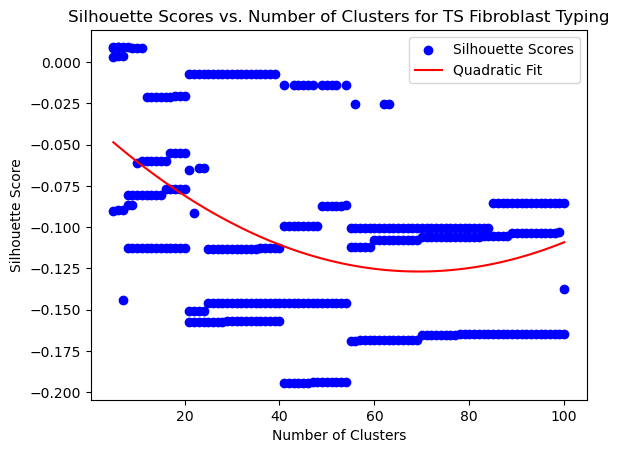

In [9]:
# Extracting x (n_clusters) and y (silhouette scores)
n_clusters = []
silhouette_scores = []

for key, score in combined_silhouette_scores.items():
    # Extract n_clusters from the key 'kmeans_n_clusters_run'
    parts = key.split('_')
    n_clusters.append(int(parts[1]))  # n_clusters is the second part
    silhouette_scores.append(score)

# Convert lists to numpy arrays for plotting
n_clusters = np.array(n_clusters)
silhouette_scores = np.array(silhouette_scores)

# Create scatterplot
plt.scatter(n_clusters, silhouette_scores, color='blue', label='Silhouette Scores')

# Fit a 2nd-degree polynomial to the data (quadratic fit)
coefficients = np.polyfit(n_clusters, silhouette_scores, 2)
polynomial = np.poly1d(coefficients)

# Create x-values for the line of best fit
x_fit = np.linspace(min(n_clusters), max(n_clusters), 100)
y_fit = polynomial(x_fit)

# Plot the line of best fit
plt.plot(x_fit, y_fit, color='red', label='Quadratic Fit')

# Add labels and title
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores vs. Number of Clusters for TS Fibroblast Typing')
plt.legend()

# Show plot
plt.show()

In [5]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Day 13

In [ ]:
# Load reprogramming recipes
df = pd.read_csv('data/HumanTFs_v_1.01.csv') # now comes from csv file and not straight from web
df.head()

# Load firboblast source cells
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/unperturbed"
FILE = "fibroblast.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))

adata.var['ensemblid'] = adata.var['ensemblid'].str.split('.').str[0] # JP Add this line

adata.var.head()

In [ ]:
# import scanpy as sc
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# import numpy as np

# # Normalize and log-transform the data
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# # Extract the count matrix and ensure it is a dense NumPy array
# X = adata.X

# # Convert sparse matrix to dense if necessary
# if hasattr(X, 'toarray'):
#     X = X.toarray()

# # Standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # List of cluster numbers to test
# cluster_numbers = list(range(2, 101))

# # Number of runs per cluster number
# n_runs = 3

# # Loop over cluster numbers and runs
# for n_clusters in cluster_numbers:
#     for run in range(1, n_runs + 1):
#         # Print the current iteration
#         print(f"Now clustering kmeans_{n_clusters}_{run}:")
        
#         # Perform K-means clustering
#         kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, random_state=42 + run)
#         adata.obs[f'kmeans_{n_clusters}_{run}'] = kmeans.fit_predict(X_scaled)
        
#         # Print that the results have been written to adata.obs
#         print(f"kmeans_{n_clusters}_{run} has been written to obs")

# # Check the updated obs
# print(adata.obs.head())


In [ ]:
import scanpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Normalize and log-transform the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Extract the count matrix and ensure it is a dense NumPy array
X = adata.X

# Convert sparse matrix to dense if necessary
if hasattr(X, 'toarray'):
    X = X.toarray()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# List of cluster numbers to test
cluster_numbers = list(range(5, 50))

# Number of runs per cluster number
n_runs = 3

# Initialize dictionary to store silhouette scores
silhouette_scores = {n: [] for n in cluster_numbers}

# Loop over cluster numbers and runs
for n_clusters in cluster_numbers:
    for run in range(1, n_runs + 1):
        # Print the current iteration
        print(f"Now clustering kmeans_{n_clusters}_{run}:")
        
        # Perform K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, random_state=42 + run)
        cluster_labels = kmeans.fit_predict(X_scaled)
        adata.obs[f'kmeans_{n_clusters}_{run}'] = cluster_labels
        
        # Calculate silhouette score
        if n_clusters > 1:  # Silhouette score is only defined for n_clusters > 1
            score = silhouette_score(X_scaled, cluster_labels)
            silhouette_scores[n_clusters].append(score)
            print(f"Silhouette score for kmeans_{n_clusters}_{run}: {score:.4f}")
        else:
            silhouette_scores[n_clusters].append(None)
            print(f"Silhouette score for kmeans_{n_clusters}_{run}: Not applicable (n_clusters <= 1)")

        # Print that the results have been written to adata.obs
        print(f"kmeans_{n_clusters}_{run} has been written to obs")

# Print the silhouette scores dictionary
print("Silhouette scores dictionary:")
print(silhouette_scores)

# Check the updated obs
print(adata.obs.head())


# Day 12

## Summarize the fibroblast data in adata

### General informtion

In [ ]:
# Load reprogramming recipes
df = pd.read_csv('data/HumanTFs_v_1.01.csv') # now comes from csv file and not straight from web
df.head()

# Load firboblast source cells
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/unperturbed"
FILE = "fibroblast.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))

adata.var['ensemblid'] = adata.var['ensemblid'].str.split('.').str[0] # JP Add this line

adata.var.head()

In [ ]:
adata.obs['donor'].values.unique()

In [ ]:
adata.obs['']

### Which are TFs?

In [ ]:
break

# Day 11

In [ ]:
""" Copied from Joshua's notebook, which was copied from mine. Theoretically, this should be Day 10 work with minor changes / debugging,
and this is the code the SLURM job is based on.
IMPORTANT QUESTION (review code): When we translate gene names from one type to another, are their names actually being updated in either the Human TFs csv or in the adata object?"""

In [ ]:
# Load reprogramming recipes
df = pd.read_csv('data/HumanTFs_v_1.01.csv') # now comes from csv file and not straight from web
df.head()

# Load firboblast source cells
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/unperturbed"
FILE = "fibroblast.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))

adata.var['ensemblid'] = adata.var['ensemblid'].str.split('.').str[0] # JP Add this line

adata.var.head()

In [ ]:

def translate_ids(list):
    # Extract base IDs from list_b by removing version numbers
    new_list = [id.split('.')[0] for id in list]
    return new_list

#ensembl ids from the counts matrix
counts_ensid_list = adata.var['ensemblid'].values.tolist()

# there were version numbers ending with " .'#' " that needed to be removed
counts_ensid_list = translate_ids(counts_ensid_list)


# ensembl ids from the transcription factor list, which in this case is also the perturbation list (testing one at a time)
tf_ensid_list = df['Ensembl ID'].values.tolist()


def validate_ensembl_tfs(tf_ensid_list, counts_ensid_list):
    missing_tfs = []
    for TF in tf_ensid_list:
        if TF not in counts_ensid_list:
            missing_tfs.append(TF)
    
    if missing_tfs:
        print("TFs not found in counts_ensid_list:")
        for tf in missing_tfs:
            print(tf)
        return False
    
    return True


validate_ensembl_tfs(tf_ensid_list, counts_ensid_list)

# when we perturb each tf in tf_ensid_list, we are just going to skip the one problematic one
problem_ens_ids = ['ZNF73_HUMAN', 'ENSG00000204828', 'DUX1_HUMAN', 'DUX3_HUMAN', 'ENSG00000262156', 'ENSG00000196101']

In [ ]:
print(len(tf_ensid_list))
print(len(problem_ens_ids))
tf_ensid_list = [id for id in tf_ensid_list if id not in problem_ens_ids]
print(len(tf_ensid_list))

In [ ]:
def iterate_perturb_id_counts(adata, tf_list, scalar_list):
    """
    Applies perturbations to the expression data of specified transcription factors across multiple scalars 
    and stores the resulting AnnData objects in a dictionary.

    This function performs the following steps:
    1. Iterates over a list of scalar values.
    2. For each scalar, creates a copy of the AnnData object to preserve the original data.
    3. Applies the `perturb_counts` function to scale the expression data of genes listed in `tf_list` by
       the maximum gene expression of each cell and the current scalar.
    4. Stores the perturbed AnnData object in a dictionary with the scalar as the key.

    Parameters:
    tf_list (list): A list of gene symbols (transcription factors) to be perturbed.
    scalar_list (list): A list of scalar values for scaling the gene expression.
    adata (AnnData): The AnnData object containing gene expression data (cells x genes).

    Returns:
    dict: A dictionary where keys are scalar values and values are the corresponding perturbed AnnData objects.
    """
    
    adata_dict = {}
    
    for scalar in scalar_list:
        # Create a copy of the AnnData object for each scalar value
        adata_temp = adata.copy()
        
        # Apply perturb_counts to the copied AnnData object
        perturbed_adata = perturb_id_counts(adata_temp, tf_list, scalar) # JP change this line
        
        # Store the perturbed AnnData object in the dictionary with scalar as the key
        adata_dict[scalar] = perturbed_adata
    
    return adata_dict

def perturb_id_counts(adata, tf_list, scalar): 
    """
    Applies a perturbation to the expression data of specific genes in an AnnData object.

    This function performs the following steps:
    1. Computes the maximum gene expression level for each cell.
    2. Applies a scaling operation to the expression levels of genes listed in `tf_list`.
       - Each entry of these genes in the matrix is multiplied by the maximum expression level 
         of its respective cell and a specified scalar value.
    3. Updates the AnnData object with new columns:
       - 'scaled': A boolean column indicating whether each gene is in the `tf_list`.
       - 'scaled_by': Contains the scaling factor used for each gene (the product of the maximum 
         expression level of each cell and the scalar), or `1` if the gene was not in `tf_list`.
    
    Parameters:
    tf_list (list): A list of gene symbols to be perturbed.
    scalar (float): The scalar value used to scale the expression levels.
    adata (AnnData): The AnnData object containing gene expression data.

    Returns:
    AnnData: The updated AnnData object with applied perturbations and new columns.
    """

    # Create a boolean mask for genes in tf_list
    gene_mask = adata.var['ensemblid'].isin(tf_list)
    
    # Save the original state of the parameter objects, in case some tfs do not translate (failsafe)
    original_X = adata.X.copy()
    original_gene_mask = gene_mask.copy()
    
    # Compute maximum expression level of each cell
    max_exp = np.max(adata.X, axis=1)

    """This is new today. v """
    # Raise an error if any of the gene names in tf_list do not match column names (we will manually update these in adata):
    missing_genes = [gene for gene in tf_list if gene not in adata.var['ensemblid'].values]
    
    if missing_genes:
        # Restore original parameter objects
        adata.X = original_X
        gene_mask = original_gene_mask
        raise ValueError(f"Genes {missing_genes} not found in anndata object")

    else:    
        
        # Apply the scaling operation to the specified genes
        adata.X[:, gene_mask] = max_exp * scalar
        
        # Add/Update 'scaled' column in var
        adata.var['scaled'] = gene_mask
        
        # Add/Update 'scaled_by' column in var
        adata.var['scaled_by'] = scalar  # Default value for genes not in tf_list

        # Add/Update 'scaled_by' column in var
        adata.obs['U'] = scalar  # Default value for genes not in tf_list
    # adata.var = 
    return adata



In [ ]:
# import os # JP change this line (all imports go at the top !)

output_directory = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/all-tfs"
scalars = [0.5, 0.75, 1.001]

# Filter tf_ensid_list to remove problematic Ensembl IDs
tf_ensid_list = [id for id in tf_ensid_list if id not in problem_ens_ids]
print(f"Total Ensembl IDs to process: {len(tf_ensid_list)}")

# Clean Ensembl IDs in adata.var['ensemblid'] to remove anything after '.'
cleaned_ensembl_ids = adata.var['ensemblid'].str.split('.').str[0]

for i in range(len(tf_ensid_list)):
    try:
        print(f"\nProcessing index: {i}")
        val = df['Ensembl ID'].iloc[i]
        TFs = val.split()  # Split in case there are multiple TFs
        print(f"Current TFs: {TFs}")

        # Check if all TFs are in the cleaned Ensembl IDs
        missing_in_adata = [tf for tf in TFs if tf not in cleaned_ensembl_ids.values]
        if missing_in_adata:
            print(f"Skipping missing genes: {missing_in_adata}")
            continue  # Skip this set of TFs if any are missing

        # Validate TFs with counts_ensid_list
        if validate_ensembl_tfs(tf_ensid_list, counts_ensid_list):
            TFs_str = "_".join(TFs)
            output_path = os.path.join(output_directory, f"{TFs_str}.h5ad")

            # Check if the file already exists
            if os.path.exists(output_path):
                print(f"{output_path} already exists: continuing to next TF!")
                continue

            print(f"Perturbing TFs: {TFs}")
            adataDict = iterate_perturb_id_counts(adata.copy(), TFs, scalars)

            # Concatenate all AnnData objects along the observations axis
            concatenated_adata = ad.concat(list(adataDict.values()), axis=0)

            # Copy var information from the original AnnData
            concatenated_adata.var = adata.var.copy()

            # JP remove the below lines. They were specific to reprogramming information but not important for the human TF
            # Save reprogramming metadata into the concatenated_adata.obs table
            # concatenated_adata.obs['Source_cells'] = df['Source cells'].iloc[i]
            # concatenated_adata.obs['Target_cells'] = df['Target cells'].iloc[i]
            # concatenated_adata.obs['Treatment'] = df['Treatment'].iloc[i]
            # concatenated_adata.obs['Species'] = df['Species'].iloc[i]
            # concatenated_adata.obs['Cell_Transplantation'] = df['Cell Transplantation'].iloc[i]
            # concatenated_adata.obs['Published_Year'] = df['Published Year'].iloc[i]
            # concatenated_adata.obs['PMID'] = df['PMID'].iloc[i]
            # concatenated_adata.obs
            
            # Save the concatenated AnnData object to the file
            concatenated_adata.write_h5ad(output_path)
            print("    File created successfully")
        else:
            print(f"The file made from {val} could not be created.")
    except Exception as e:
        print(f"Error encountered at index {i}: {e}")

print('All recipes complete!')


In [ ]:
output_path

In [ ]:
df

# Day 10


## Load Data (prev day)

In [ ]:
# Load reprogramming recipes
df = pd.read_csv('https://raw.githubusercontent.com/Jpickard1/scFoundationModels/main/notebooks/reprogramming/data/HumanTFs_v_1.01.csv')
df.head()

# Load firboblast source cells
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/unperturbed"
FILE = "fibroblast.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))


adata.var.head()

## Check for invalid ensembl ids (day 9)

In [ ]:

def translate_ids(list):
    # Extract base IDs from list_b by removing version numbers
    new_list = [id.split('.')[0] for id in list]
    return new_list

#ensembl ids from the counts matrix
counts_ensid_list = adata.var['ensemblid'].values.tolist()
# there were version numbers ending with " .'#' " that needed to be removed
counts_ensid_list = translate_ids(counts_ensid_list)


# ensembl ids from the transcription factor list, which in this case is also the perturbation list (testing one at a time)
tf_ensid_list = df['Ensembl ID'].values.tolist()

# def validate_ensembl_tfs(tf_ensid_list, counts_ensid_list):
#     for TF in tf_ensid_list:
#         if TF not in counts_ensid_list:
#             print(TF)
#             return False
#     return True


def validate_ensembl_tfs(tf_ensid_list, counts_ensid_list):
    missing_tfs = []
    for TF in tf_ensid_list:
        if TF not in counts_ensid_list:
            missing_tfs.append(TF)
    
    if missing_tfs:
        print("TFs not found in counts_ensid_list:")
        for tf in missing_tfs:
            print(tf)
        return False
    
    return True


validate_ensembl_tfs(tf_ensid_list, counts_ensid_list)

# when we perturb each tf in tf_ensid_list, we are just going to skip the one problematic one
problem_ens_ids = ['ZNF73_HUMAN', 'ENSG00000204828', 'DUX1_HUMAN', 'DUX3_HUMAN', 'ENSG00000262156', 'ENSG00000196101']

In [ ]:
print(len(tf_ensid_list))
print(len(problem_ens_ids))
tf_ensid_list = [id for id in tf_ensid_list if id not in problem_ens_ids]
print(len(tf_ensid_list))

In [ ]:
adata.var.head()  # Display the first 10 gene names


In [ ]:
# Check the first few cleaned Ensembl IDs to verify the format
print(cleaned_ensembl_ids[:10])

# Check if the specific missing gene is in the cleaned list
print('ENSG00000137203' in cleaned_ensembl_ids.values)


In [ ]:
def iterate_perturb_id_counts(adata, tf_list, scalar_list):
    """
    Applies perturbations to the expression data of specified transcription factors across multiple scalars 
    and stores the resulting AnnData objects in a dictionary.

    This function performs the following steps:
    1. Iterates over a list of scalar values.
    2. For each scalar, creates a copy of the AnnData object to preserve the original data.
    3. Applies the `perturb_counts` function to scale the expression data of genes listed in `tf_list` by
       the maximum gene expression of each cell and the current scalar.
    4. Stores the perturbed AnnData object in a dictionary with the scalar as the key.

    Parameters:
    tf_list (list): A list of gene symbols (transcription factors) to be perturbed.
    scalar_list (list): A list of scalar values for scaling the gene expression.
    adata (AnnData): The AnnData object containing gene expression data (cells x genes).

    Returns:
    dict: A dictionary where keys are scalar values and values are the corresponding perturbed AnnData objects.
    """
    
    adata_dict = {}
    
    for scalar in scalar_list:
        # Create a copy of the AnnData object for each scalar value
        adata_temp = adata.copy()
        
        # Apply perturb_counts to the copied AnnData object
        perturbed_adata = perturb_id_counts(adata_temp, tf_list, scalar)
        
        # Store the perturbed AnnData object in the dictionary with scalar as the key
        adata_dict[scalar] = perturbed_adata
    
    return adata_dict

def perturb_id_counts(adata, tf_list, scalar): 
    """
    Applies a perturbation to the expression data of specific genes in an AnnData object.

    This function performs the following steps:
    1. Computes the maximum gene expression level for each cell.
    2. Applies a scaling operation to the expression levels of genes listed in `tf_list`.
       - Each entry of these genes in the matrix is multiplied by the maximum expression level 
         of its respective cell and a specified scalar value.
    3. Updates the AnnData object with new columns:
       - 'scaled': A boolean column indicating whether each gene is in the `tf_list`.
       - 'scaled_by': Contains the scaling factor used for each gene (the product of the maximum 
         expression level of each cell and the scalar), or `1` if the gene was not in `tf_list`.
    
    Parameters:
    tf_list (list): A list of gene symbols to be perturbed.
    scalar (float): The scalar value used to scale the expression levels.
    adata (AnnData): The AnnData object containing gene expression data.

    Returns:
    AnnData: The updated AnnData object with applied perturbations and new columns.
    """

    # Create a boolean mask for genes in tf_list
    gene_mask = adata.var['ensemblid'].isin(tf_list)
    
    # Save the original state of the parameter objects, in case some tfs do not translate (failsafe)
    original_X = adata.X.copy()
    original_gene_mask = gene_mask.copy()
    
    # Compute maximum expression level of each cell
    max_exp = np.max(adata.X, axis=1)

    """This is new today. v """
    # Raise an error if any of the gene names in tf_list do not match column names (we will manually update these in adata):
    missing_genes = [gene for gene in tf_list if gene not in adata.var['ensemblid'].values]
    
    if missing_genes:
        # Restore original parameter objects
        adata.X = original_X
        gene_mask = original_gene_mask
        raise ValueError(f"Genes {missing_genes} not found in anndata object")

    else:    
        
        # Apply the scaling operation to the specified genes
        adata.X[:, gene_mask] = max_exp * scalar
        
        # Add/Update 'scaled' column in var
        adata.var['scaled'] = gene_mask
        
        # Add/Update 'scaled_by' column in var
        adata.var['scaled_by'] = scalar  # Default value for genes not in tf_list

        # Add/Update 'scaled_by' column in var
        adata.obs['U'] = scalar  # Default value for genes not in tf_list
    # adata.var = 
    return adata



In [ ]:
import os

output_directory = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/all-tfs"
scalars = [0.5, 0.75, 1.001, 1.25, 1.5]

# Filter tf_ensid_list to remove problematic Ensembl IDs
tf_ensid_list = [id for id in tf_ensid_list if id not in problem_ens_ids]
print(f"Total Ensembl IDs to process: {len(tf_ensid_list)}")

# Clean Ensembl IDs in adata.var['ensemblid'] to remove anything after '.'
cleaned_ensembl_ids = adata.var['ensemblid'].str.split('.').str[0]

for i in range(len(tf_ensid_list)):
    try:
        print(f"\nProcessing index: {i}")
        val = df['Ensembl ID'].iloc[i]
        TFs = val.split()  # Split in case there are multiple TFs
        print(f"Current TFs: {TFs}")

        # Check if all TFs are in the cleaned Ensembl IDs
        missing_in_adata = [tf for tf in TFs if tf not in cleaned_ensembl_ids.values]
        if missing_in_adata:
            print(f"Skipping missing genes: {missing_in_adata}")
            continue  # Skip this set of TFs if any are missing
        
        # Validate TFs with counts_ensid_list
        if validate_ensembl_tfs(tf_ensid_list, counts_ensid_list):
            TFs_str = "_".join(TFs)
            output_path = os.path.join(output_directory, f"{TFs_str}.h5ad")

            # Check if the file already exists
            if os.path.exists(output_path):
                print(f"{output_path} already exists: continuing to next TF!")
                continue

            print(f"Perturbing TFs: {TFs}")
            adataDict = iterate_perturb_id_counts(adata.copy(), TFs, scalars)

            # Concatenate all AnnData objects along the observations axis
            concatenated_adata = ad.concat(list(adataDict.values()), axis=0)

            # Copy var information from the original AnnData
            concatenated_adata.var = adata.var.copy()

            # Save reprogramming metadata into the concatenated_adata.obs table
            concatenated_adata.obs['Source_cells'] = df['Source cells'].iloc[i]
            concatenated_adata.obs['Target_cells'] = df['Target cells'].iloc[i]
            concatenated_adata.obs['Treatment'] = df['Treatment'].iloc[i]
            concatenated_adata.obs['Species'] = df['Species'].iloc[i]
            concatenated_adata.obs['Cell_Transplantation'] = df['Cell Transplantation'].iloc[i]
            concatenated_adata.obs['Published_Year'] = df['Published Year'].iloc[i]
            concatenated_adata.obs['PMID'] = df['PMID'].iloc[i]

            # Save the concatenated AnnData object to the file
            concatenated_adata.write_h5ad(output_path)
            print("    File created successfully")
        else:
            print(f"The file made from {val} could not be created.")
    except Exception as e:
        print(f"Error encountered at index {i}: {e}")

print('All recipes complete!')


## Perform perturbation

### Perturbation function definitions (old)

In [ ]:

def iterate_perturb_counts(adata, tf_list, scalar_list):
    """
    Applies perturbations to the expression data of specified transcription factors across multiple scalars 
    and stores the resulting AnnData objects in a dictionary.

    This function performs the following steps:
    1. Iterates over a list of scalar values.
    2. For each scalar, creates a copy of the AnnData object to preserve the original data.
    3. Applies the `perturb_counts` function to scale the expression data of genes listed in `tf_list` by
       the maximum gene expression of each cell and the current scalar.
    4. Stores the perturbed AnnData object in a dictionary with the scalar as the key.

    Parameters:
    tf_list (list): A list of gene symbols (transcription factors) to be perturbed.
    scalar_list (list): A list of scalar values for scaling the gene expression.
    adata (AnnData): The AnnData object containing gene expression data (cells x genes).

    Returns:
    dict: A dictionary where keys are scalar values and values are the corresponding perturbed AnnData objects.
    """
    
    adata_dict = {}
    
    for scalar in scalar_list:
        # Create a copy of the AnnData object for each scalar value
        adata_temp = adata.copy()
        
        # Apply perturb_counts to the copied AnnData object
        perturbed_adata = perturb_counts(adata_temp, tf_list, scalar)
        
        # Store the perturbed AnnData object in the dictionary with scalar as the key
        adata_dict[scalar] = perturbed_adata
    
    return adata_dict

def perturb_counts(adata, tf_list, scalar): 
    """
    Applies a perturbation to the expression data of specific genes in an AnnData object.

    This function performs the following steps:
    1. Computes the maximum gene expression level for each cell.
    2. Applies a scaling operation to the expression levels of genes listed in `tf_list`.
       - Each entry of these genes in the matrix is multiplied by the maximum expression level 
         of its respective cell and a specified scalar value.
    3. Updates the AnnData object with new columns:
       - 'scaled': A boolean column indicating whether each gene is in the `tf_list`.
       - 'scaled_by': Contains the scaling factor used for each gene (the product of the maximum 
         expression level of each cell and the scalar), or `1` if the gene was not in `tf_list`.
    
    Parameters:
    tf_list (list): A list of gene symbols to be perturbed.
    scalar (float): The scalar value used to scale the expression levels.
    adata (AnnData): The AnnData object containing gene expression data.

    Returns:
    AnnData: The updated AnnData object with applied perturbations and new columns.
    """

    # Create a boolean mask for genes in tf_list
    gene_mask = adata.var['gene_symbol'].isin(tf_list)
    
    # Save the original state of the parameter objects, in case some tfs do not translate (failsafe)
    original_X = adata.X.copy()
    original_gene_mask = gene_mask.copy()
    
    # Compute maximum expression level of each cell
    max_exp = np.max(adata.X, axis=1)

    """This is new today. v """
    # Raise an error if any of the gene names in tf_list do not match column names (we will manually update these in adata):
    missing_genes = [gene for gene in tf_list if gene not in adata.var['gene_symbol'].values]
    
    if missing_genes:
        # Restore original parameter objects
        adata.X = original_X
        gene_mask = original_gene_mask
        raise ValueError(f"Genes {missing_genes} not found in anndata object")

    else:    
        
        # Apply the scaling operation to the specified genes
        adata.X[:, gene_mask] = max_exp * scalar
        
        # Add/Update 'scaled' column in var
        adata.var['scaled'] = gene_mask
        
        # Add/Update 'scaled_by' column in var
        adata.var['scaled_by'] = scalar  # Default value for genes not in tf_list

        # Add/Update 'scaled_by' column in var
        adata.obs['U'] = scalar  # Default value for genes not in tf_list
    # adata.var = 
    return adata



### Saving perturbations (new)

In [ ]:
output_directory = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/all-tfs"
scalars = [0.5, 0.75, 1.001, 1.25, 1.5]
print(len(tf_ensid_list))

tf_ensid_list = [id for id in tf_ensid_list if id not in problem_ens_ids]
print(len(tf_ensid_list))

for i in range(len(tf_ensid_list)):
    val = df['Ensembl ID'].iloc[i]
    # this handles the case where there is more than one tf to perturb in the same file, but in this case there is just the one
    TFs = val.split()
    # take out all the ensembl ids where there was no match in the couns matrix

    if validate_ensembl_tfs(tf_ensid_list, counts_ensid_list):
        # Join the TFs list into a string for the filename
        TFs_str = "_".join(TFs)
        
        # Generate the file path for saving
        file_name = f"{TFs_str}.h5ad"
        output_path = os.path.join(output_directory, file_name)

        # Check if the file already exists
        if os.path.exists(output_path):
            print(output_path + " already exists: continue!")
            continue
        
        print(TFs)
        adataDict = iterate_perturb_counts(adata.copy(), TFs, scalars)

        # Concatenate all AnnData objects along the observations axis
        concatenated_adata = ad.concat(list(adataDict.values()), axis=0)

        # This is the line was added today to fix the bug
        concatenated_adata.var = adata.var.copy()

        # Save reprogramming metadata into the concatenated_adata.obs table
        concatenated_adata.obs['Source_cells'] = df['Source cells'].iloc[i]
        concatenated_adata.obs['Target_cells'] = df['Target cells'].iloc[i]
        concatenated_adata.obs['Treatment'] = df['Treatment'].iloc[i]
        concatenated_adata.obs['Species'] = df['Species'].iloc[i]
        concatenated_adata.obs['Cell_Transplantation'] = df['Cell Transplantation'].iloc[i]
        concatenated_adata.obs['Published_Year'] = df['Published Year'].iloc[i]
        concatenated_adata.obs['PMID'] = df['PMID'].iloc[i]
        
        # Save the concatenated AnnData object to the file
        concatenated_adata.write_h5ad(output_path)
        print("    file created")
    else:
        print("The file made from ", val ," could not be created")
print('All recipes complete!')

In [ ]:
# Check if TFs are in adata
# missing_genes = [tf for tf in TFs if tf not in adata.var.index]
# if missing_genes:
#     print(f"Missing genes in AnnData object: {missing_genes}")

adata.var.index

In [ ]:
for i in range(len(tf_ensid_list)):
    print(f"Processing index {i}")
    val = df['Ensembl ID'].iloc[i]
    TFs = val.split()
    
    print(f"TFs: {TFs}")
    
    tf_ensid_list_filtered = [id for id in problem_ens_ids if id not in tf_ensid_list]
    
    if not validate_ensembl_tfs(counts_ensid_list, tf_ensid_list_filtered):
        print("Validation failed")
        continue
    
    TFs_str = "_".join(TFs)
    file_name = f"{TFs_str}.h5ad"
    output_path = os.path.join(output_directory, file_name)
    
    if os.path.exists(output_path):
        print(f"{output_path} already exists")
        continue
    
    print(f"Creating file: {output_path}")
    
    adataDict = iterate_perturb_counts(adata.copy(), TFs, scalars)
    concatenated_adata = ad.concat(list(adataDict.values()), axis=0)
    concatenated_adata.var = adata.var.copy()
    
    concatenated_adata.obs['Source_cells'] = df['Source cells'].iloc[i]
    concatenated_adata.obs['Target_cells'] = df['Target cells'].iloc[i]
    concatenated_adata.obs['Treatment'] = df['Treatment'].iloc[i]
    concatenated_adata.obs['Species'] = df['Species'].iloc[i]
    concatenated_adata.obs['Cell_Transplantation'] = df['Cell Transplantation'].iloc[i]
    concatenated_adata.obs['Published_Year'] = df['Published Year'].iloc[i]
    concatenated_adata.obs['PMID'] = df['PMID'].iloc[i]
    
    concatenated_adata.write_h5ad(output_path)
    print(f"File created: {output_path}")


In [ ]:
break

# Day 9

In [ ]:
""" Generating the perturbation files for all of the Human TFs (perturbation of 1, individually). 
Day 8 is designed for the paper spreadsheet, but some of the TFs column is still not formatted properly (not fixing this today)
"""
""" Important: Some of the same variable names are being used in the all tf experiment as in the paper experiment: both in the same situations, e.g. TFs is the TFs, but different ones between experiments"""

## Set up

In [ ]:
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sp
import os

def iterate_perturb_counts(adata, tf_list, scalar_list):
    """
    Applies perturbations to the expression data of specified transcription factors across multiple scalars 
    and stores the resulting AnnData objects in a dictionary.

    This function performs the following steps:
    1. Iterates over a list of scalar values.
    2. For each scalar, creates a copy of the AnnData object to preserve the original data.
    3. Applies the `perturb_counts` function to scale the expression data of genes listed in `tf_list` by
       the maximum gene expression of each cell and the current scalar.
    4. Stores the perturbed AnnData object in a dictionary with the scalar as the key.

    Parameters:
    tf_list (list): A list of gene symbols (transcription factors) to be perturbed.
    scalar_list (list): A list of scalar values for scaling the gene expression.
    adata (AnnData): The AnnData object containing gene expression data (cells x genes).

    Returns:
    dict: A dictionary where keys are scalar values and values are the corresponding perturbed AnnData objects.
    """
    
    adata_dict = {}
    
    for scalar in scalar_list:
        # Create a copy of the AnnData object for each scalar value
        adata_temp = adata.copy()
        
        # Apply perturb_counts to the copied AnnData object
        perturbed_adata = perturb_counts(adata_temp, tf_list, scalar)
        
        # Store the perturbed AnnData object in the dictionary with scalar as the key
        adata_dict[scalar] = perturbed_adata
    
    return adata_dict

def perturb_counts(adata, tf_list, scalar): 
    """
    Applies a perturbation to the expression data of specific genes in an AnnData object.

    This function performs the following steps:
    1. Computes the maximum gene expression level for each cell.
    2. Applies a scaling operation to the expression levels of genes listed in `tf_list`.
       - Each entry of these genes in the matrix is multiplied by the maximum expression level 
         of its respective cell and a specified scalar value.
    3. Updates the AnnData object with new columns:
       - 'scaled': A boolean column indicating whether each gene is in the `tf_list`.
       - 'scaled_by': Contains the scaling factor used for each gene (the product of the maximum 
         expression level of each cell and the scalar), or `1` if the gene was not in `tf_list`.
    
    Parameters:
    tf_list (list): A list of gene symbols to be perturbed.
    scalar (float): The scalar value used to scale the expression levels.
    adata (AnnData): The AnnData object containing gene expression data.

    Returns:
    AnnData: The updated AnnData object with applied perturbations and new columns.
    """

    # Create a boolean mask for genes in tf_list
    gene_mask = adata.var['gene_symbol'].isin(tf_list)
    
    # Save the original state of the parameter objects, in case some tfs do not translate (failsafe)
    original_X = adata.X.copy()
    original_gene_mask = gene_mask.copy()
    
    # Compute maximum expression level of each cell
    max_exp = np.max(adata.X, axis=1)

    """This is new today. v """
    # Raise an error if any of the gene names in tf_list do not match column names (we will manually update these in adata):
    missing_genes = [gene for gene in tf_list if gene not in adata.var['gene_symbol'].values]
    
    if missing_genes:
        # Restore original parameter objects
        adata.X = original_X
        gene_mask = original_gene_mask
        raise ValueError(f"Genes {missing_genes} not found in anndata object")

    else:    
        
        # Apply the scaling operation to the specified genes
        adata.X[:, gene_mask] = max_exp * scalar
        
        # Add/Update 'scaled' column in var
        adata.var['scaled'] = gene_mask
        
        # Add/Update 'scaled_by' column in var
        adata.var['scaled_by'] = scalar  # Default value for genes not in tf_list

        # Add/Update 'scaled_by' column in var
        adata.obs['U'] = scalar  # Default value for genes not in tf_list
    # adata.var = 
    return adata



In [ ]:

def translate_ids(list):
    # Extract base IDs from list_b by removing version numbers
    new_list = [id.split('.')[0] for id in list]
    return new_list

#ensembl ids from the counts matrix
counts_ensid_list = adata.var['ensemblid'].values.tolist()
counts_ensid_list = translate_ids(adata_id_list)


# ensembl ids from the transcription factor list, which in this case is also the perturbation list (testing one at a time)
tf_ensid_list = df['Ensembl ID'].values.tolist()


def validate_ensembl_tfs(tf_ensid_list, counts_ensid_list):
    for TF in ensembl_TFs:
        if TF not in counts_ensid_list:
            print(TF)
            return False
    return True

validate_ensembl_tfs(tf_ensid_list, counts_ensid_list)

# when we perturb each tf in tf_ensid_list, we are just going to skip the one problematic one
problem_ens_ids = ['ZNF73_HUMAN']




In [ ]:
df.head()

## Load Data

In [ ]:
# Load reprogramming recipes
df = pd.read_csv('https://raw.githubusercontent.com/Jpickard1/scFoundationModels/main/notebooks/reprogramming/data/HumanTFs_v_1.01.csv')
df.head()

# Load firboblast source cells
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/unperturbed"
FILE = "fibroblast.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))
adata_gene_list = adata.var['gene_symbol'].values.tolist()

adata.var.head()

In [ ]:
output_directory = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/one-shot/perturbed"
scalars = [0.5, 0.75, 1.001]
for i in range(len(df['TFs'])):
    val = df['TFs'].iloc[i]
    TFs = val.split()
    if validateTFs(TFs, adata):

        # Join the TFs list into a string for the filename
        TFs_str = "_".join(TFs)
        
        # Generate the file path for saving
        file_name = f"{TFs_str}.h5ad"
        output_path = os.path.join(output_directory, file_name)

        # Check if the file already exists
        if os.path.exists(output_path):
            print(output_path + " already exist: continue!")
            continue
        
        print(TFs)
        adataDict = iterate_perturb_counts(adata.copy(), TFs, scalars)

        # Concatenate all AnnData objects along the observations axis
        concatenated_adata = ad.concat(list(adataDict.values()), axis=0)

        # This is the line was added today to fix the bug
        concatenated_adata.var = adata.var.copy()

        # Save reprogramming metadata into the concatenated_adata.obs table
        concatenated_adata.obs['Source_cells'] = df['Source cells'].iloc[i]
        concatenated_adata.obs['Target_cells'] = df['Target cells'].iloc[i]
        concatenated_adata.obs['Treatment'] = df['Treatment'].iloc[i]
        concatenated_adata.obs['Species'] = df['Species'].iloc[i]
        concatenated_adata.obs['Cell_Transplantation'] = df['Cell Transplantation'].iloc[i]
        concatenated_adata.obs['Published_Year'] = df['Published Year'].iloc[i]
        concatenated_adata.obs['PMID'] = df['PMID'].iloc[i]
        
        # Save the concatenated AnnData object to the file
        concatenated_adata.write_h5ad(output_path)
        print("    file created")

print('All recipes complete!')

## Trash

In [ ]:
# def validateTFs(TFs, adata):
#     adata_gene_list = adata.var['gene_symbol'].values.tolist()
#     for TF in TFs:
#         if TF not in adata_gene_list:
#             return False
#     return True

# # # to contrast the previous experiment, here genes are named by ensembl id rather than one of their names
# ensembl_TFs = df['Ensembl ID']. values.tolist()
# # def validate_ensembl_tfs(ensembl_TFs, adata):
# #     adata_id_list = adata.var['ensemblid'].values.tolist()
# #     for TF in ensembl_TFs:
# #         if TF not in adata_id_list:
# #             return False
# #     return True

# # validate_ensembl_tfs(ensembl_TFs, adata



# def validate_ensembl_tfs(ensembl_TFs, new_adata_id_list):
#     count = 0
#     # Extract Ensembl IDs from the adata object

#     # Initialize a flag to check if all IDs are found
#     all_found = True
#     # Iterate through the list of Ensembl IDs to validate
#     for TF in ensembl_TFs:
#         if TF not in adata_id_list:
#             # Print the missing Ensembl ID
#             #print(f"{TF} not found in adata.var['ensemblid']")
#             count += 1
#             # Set the flag to False if an ID is missing
#             all_found = False
#     # Return the final status of the validation
#     print(len(adata_id_list))
#     print(len(ensembl_TFs))
#     print(count)
#     return all_found


# Day 8

Generatting the perturbation files

## Set up

In [ ]:
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sp
import os

def iterate_perturb_counts(adata, tf_list, scalar_list):
    """
    Applies perturbations to the expression data of specified transcription factors across multiple scalars 
    and stores the resulting AnnData objects in a dictionary.

    This function performs the following steps:
    1. Iterates over a list of scalar values.
    2. For each scalar, creates a copy of the AnnData object to preserve the original data.
    3. Applies the `perturb_counts` function to scale the expression data of genes listed in `tf_list` by
       the maximum gene expression of each cell and the current scalar.
    4. Stores the perturbed AnnData object in a dictionary with the scalar as the key.

    Parameters:
    tf_list (list): A list of gene symbols (transcription factors) to be perturbed.
    scalar_list (list): A list of scalar values for scaling the gene expression.
    adata (AnnData): The AnnData object containing gene expression data (cells x genes).

    Returns:
    dict: A dictionary where keys are scalar values and values are the corresponding perturbed AnnData objects.
    """
    
    adata_dict = {}
    
    for scalar in scalar_list:
        # Create a copy of the AnnData object for each scalar value
        adata_temp = adata.copy()
        
        # Apply perturb_counts to the copied AnnData object
        perturbed_adata = perturb_counts(adata_temp, tf_list, scalar)
        
        # Store the perturbed AnnData object in the dictionary with scalar as the key
        adata_dict[scalar] = perturbed_adata
    
    return adata_dict

def perturb_counts(adata, tf_list, scalar): 
    """
    Applies a perturbation to the expression data of specific genes in an AnnData object.

    This function performs the following steps:
    1. Computes the maximum gene expression level for each cell.
    2. Applies a scaling operation to the expression levels of genes listed in `tf_list`.
       - Each entry of these genes in the matrix is multiplied by the maximum expression level 
         of its respective cell and a specified scalar value.
    3. Updates the AnnData object with new columns:
       - 'scaled': A boolean column indicating whether each gene is in the `tf_list`.
       - 'scaled_by': Contains the scaling factor used for each gene (the product of the maximum 
         expression level of each cell and the scalar), or `1` if the gene was not in `tf_list`.
    
    Parameters:
    tf_list (list): A list of gene symbols to be perturbed.
    scalar (float): The scalar value used to scale the expression levels.
    adata (AnnData): The AnnData object containing gene expression data.

    Returns:
    AnnData: The updated AnnData object with applied perturbations and new columns.
    """

    # Create a boolean mask for genes in tf_list
    gene_mask = adata.var['gene_symbol'].isin(tf_list)
    
    # Save the original state of the parameter objects, in case some tfs do not translate (failsafe)
    original_X = adata.X.copy()
    original_gene_mask = gene_mask.copy()
    
    # Compute maximum expression level of each cell
    max_exp = np.max(adata.X, axis=1)

    """This is new today. v """
    # Raise an error if any of the gene names in tf_list do not match column names (we will manually update these in adata):
    missing_genes = [gene for gene in tf_list if gene not in adata.var['gene_symbol'].values]
    
    if missing_genes:
        # Restore original parameter objects
        adata.X = original_X
        gene_mask = original_gene_mask
        raise ValueError(f"Genes {missing_genes} not found in anndata object")

    else:    
        
        # Apply the scaling operation to the specified genes
        adata.X[:, gene_mask] = max_exp * scalar
        
        # Add/Update 'scaled' column in var
        adata.var['scaled'] = gene_mask
        
        # Add/Update 'scaled_by' column in var
        adata.var['scaled_by'] = scalar  # Default value for genes not in tf_list

        # Add/Update 'scaled_by' column in var
        adata.obs['U'] = scalar  # Default value for genes not in tf_list
    # adata.var = 
    return adata

def validateTFs(TFs, adata):
    adata_gene_list = adata.var['gene_symbol'].values.tolist()
    for TF in TFs:
        if TF not in adata_gene_list:
            return False
    return True

## Load Data

In [ ]:
# Load reprogramming recipes
df = pd.read_csv('data/recipe_table_9_6_2024.csv')
df.head()

# Load firboblast source cells
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/unperturbed"
FILE = "fibroblast.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))
adata_gene_list = adata.var['gene_symbol'].values.tolist()

## Make Files

In [ ]:
output_directory = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/one-shot/perturbed"
scalars = [0.5, 0.75, 1.001]
for i in range(len(df['TFs'])):
    val = df['TFs'].iloc[i]
    TFs = val.split()
    if validateTFs(TFs, adata):

        # Join the TFs list into a string for the filename
        TFs_str = "_".join(TFs)
        
        # Generate the file path for saving
        file_name = f"{TFs_str}.h5ad"
        output_path = os.path.join(output_directory, file_name)

        # Check if the file already exists
        if os.path.exists(output_path):
            print(output_path + " already exist: continue!")
            continue
        
        print(TFs)
        adataDict = iterate_perturb_counts(adata.copy(), TFs, scalars)

        # Concatenate all AnnData objects along the observations axis
        concatenated_adata = ad.concat(list(adataDict.values()), axis=0)

        # This is the line was added today to fix the bug
        concatenated_adata.var = adata.var.copy()

        # Save reprogramming metadata into the concatenated_adata.obs table
        concatenated_adata.obs['Source_cells'] = df['Source cells'].iloc[i]
        concatenated_adata.obs['Target_cells'] = df['Target cells'].iloc[i]
        concatenated_adata.obs['Treatment'] = df['Treatment'].iloc[i]
        concatenated_adata.obs['Species'] = df['Species'].iloc[i]
        concatenated_adata.obs['Cell_Transplantation'] = df['Cell Transplantation'].iloc[i]
        concatenated_adata.obs['Published_Year'] = df['Published Year'].iloc[i]
        concatenated_adata.obs['PMID'] = df['PMID'].iloc[i]
        
        # Save the concatenated AnnData object to the file
        concatenated_adata.write_h5ad(output_path)
        print("    file created")

print('All recipes complete!')

In [ ]:
df['TFs']

## Debug

In [ ]:
adata

In [ ]:
adata.var

In [ ]:
padata = perturb_counts(adata, ['DDX11L1'], 1)


In [ ]:
concatenated_adata = ad.concat([adata, padata], axis=0)
concatenated_adata.var = adata.var.copy()
concatenated_adata.var

In [ ]:
adata.var

In [ ]:
concatenated_adata.var

In [ ]:
padata.var

# Day 7

# Day 6

In [ ]:
""" Changes to gene names and formatting are reflected in spreadsheet"""

# Day 5

In [ ]:
# Copied from a prev day

"""
Josh, please read: the adata.obs['scalar'] = scalar copies the scalar down for that call, associated with every cell in X. Same with ['scaled'] and ['scaled_by']
in var. This is good in case the data is later appended into one anndata object.
But my return from the perturb_counts loop (cell below this) is a dictionary of all of the perturb_counts, since appending along any axis will probably either overwrite
obs or var.
"""


def perturb_counts(tf_list, scalar, adata): 
    """
    Applies a perturbation to the expression data of specific genes in an AnnData object.

    This function performs the following steps:
    1. Computes the maximum gene expression level for each cell.
    2. Applies a scaling operation to the expression levels of genes listed in `tf_list`.
       - Each entry of these genes in the matrix is multiplied by the maximum expression level 
         of its respective cell and a specified scalar value.
    3. Updates the AnnData object with new columns:
       - 'scaled': A boolean column indicating whether each gene is in the `tf_list`.
       - 'scaled_by': Contains the scaling factor used for each gene (the product of the maximum 
         expression level of each cell and the scalar), or `1` if the gene was not in `tf_list`.
    
    Parameters:
    tf_list (list): A list of gene symbols to be perturbed.
    scalar (float): The scalar value used to scale the expression levels.
    adata (AnnData): The AnnData object containing gene expression data.

    Returns:
    AnnData: The updated AnnData object with applied perturbations and new columns.
    """
    # Save the original state of the parameter objects, in case some tfs do not translate (failsafe)
    original_X = adata.X.copy()
    original_gene_mask = gene_mask.copy()
    
    # Compute maximum expression level of each cell
    max_exp = np.max(adata.X, axis=1)
    
    # Create a boolean mask for genes in tf_list
    gene_mask = adata.var['gene_symbol'].isin(tf_list)

    """This is new today. v """
    # Raise an error if any of the gene names in tf_list do not match column names (we will manually update these in adata):
    missing_genes = [gene for gene in tf_list if gene not in adata.var['gene_symbol'].values]
    
    if missing_genes:
        # Restore original parameter objects
        adata.X = original_X
        gene_mask = original_gene_mask
        raise ValueError(f"Genes {missing_genes} not found in anndata object")

    else:
        """ This is new today. ^ """
        # Apply the scaling operation to the specified genes
        adata.X[:, gene_mask] *= max_exp[:, np.newaxis] * scalar
        
        # Add/Update 'scaled' column in var
        adata.var['scaled'] = gene_mask
        
        # Add/Update 'scaled_by' column in var
        adata.var['scaled_by'] = 1  # Default value for genes not in tf_list
        adata.var.loc[gene_mask, 'scaled_by'] = max_exp[:, np.newaxis] * scalar  # Correct scaling factor assignment
    
    return adata



In [ ]:
# Copied from a prev day

import anndata

def iterate_perturb_counts(tf_list, scalar_list, adata):
    """
    Applies perturbations to the expression data of specified transcription factors across multiple scalars 
    and stores the resulting AnnData objects in a dictionary.

    This function performs the following steps:
    1. Iterates over a list of scalar values.
    2. For each scalar, creates a copy of the AnnData object to preserve the original data.
    3. Applies the `perturb_counts` function to scale the expression data of genes listed in `tf_list` by
       the maximum gene expression of each cell and the current scalar.
    4. Stores the perturbed AnnData object in a dictionary with the scalar as the key.

    Parameters:
    tf_list (list): A list of gene symbols (transcription factors) to be perturbed.
    scalar_list (list): A list of scalar values for scaling the gene expression.
    adata (AnnData): The AnnData object containing gene expression data (cells x genes).

    Returns:
    dict: A dictionary where keys are scalar values and values are the corresponding perturbed AnnData objects.
    """
    
    adata_dict = {}
    
    for scalar in scalar_list:
        # Create a copy of the AnnData object for each scalar value
        adata_temp = adata.copy()
        
        # Apply perturb_counts to the copied AnnData object
        perturbed_adata = perturb_counts(tf_list, scalar, adata_temp)
        
        # Store the perturbed AnnData object in the dictionary with scalar as the key
        adata_dict[scalar] = perturbed_adata
    
    return adata_dict



In [ ]:

# Copied from a prev day

DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
FILE = "TS_epithelial.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))
adata_gene_list = adata.var['gene_symbol'].values.tolist()

# Print the first 5 entries
print("First 5 entries:")
print(adata_gene_list[:5])

# Print the last 5 entries
print("Last 5 entries:")
print(adata_gene_list[-5:])

In [ ]:
# outside the function so I can manipulate these directly.
# I also checked whether it matters if I do case insensitive (capitalize everything then compare) or case sensitive.
# Unsurprisingly, case sensitive has more discrepancies (45 vs. 44), with the one extra that was picked up as "Ptf1a".
# I left the case insensitive version. 

# get a list of words (potential genes, also includes and, + , etc. ) from the table from the review paper
table_1_df = pd.read_csv("/home/oliven/scFoundationModels/notebooks/reprogramming/data/table_1_data_from_paper_9_1.csv")
combined_string = ' '.join(table_1_df['Treatment'].astype(str)).replace(',', '')
word_list = combined_string.split()

# get a list of genes that appear in the data matrix
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
FILE = "TS_epithelial.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))
adata_gene_list = adata.var['gene_symbol'].values.tolist()

# New today
def check_valid_tfs(word_list, adata_gene_list):

    word_list_upper = [word.upper() for word in word_list]
    adata_gene_list_upper = [gene.upper() for gene in adata_gene_list]

    # print what does not overlap
    not_valid_gene = set(word_list_upper) - set(adata_gene_list_upper)

    print("Entries in the table that are not genes in the counts matrix: ")
    
    return list(not_valid_gene)
    
check_valid_tfs(word_list, adata_gene_list)

In [ ]:
# for those genes with multiple aliases, checking which are valid
# we have to worry about making this case insensitive just in case
multiple_alias_dict = {}
multiple_alias_dict.update({
    'P53': ['BCC7','BMFS5', 'LFS1', 'TRP53'],
    'OCT3/4': ['POU5F1', 'OCT3', 'OCT4', 'OTF4', 'MGC22487'],
    'MASH1': ['HASH1', 'BHLHa46', 'ASH1', 'ASH-1', 'ASCL1'],
    'HNF6': ['HNF6', 'HNF6A', 'ONECUT1'],
    'HB9': ['MNX1', 'HOXHB9', 'SCRA1', 'HLXB9', 'GC07M156491', 'GC07M156786', 'GC07M150530'],
    'PPARG2': ['PPARG', 'NR1C3', 'PPARG1', 'PPARgamma', 'PPAR-Gamma', 'PPARG5', 'CIMT1', 'GLM1'], 
    'PU.1': ['SPI1', 'SPI-A', 'SFPI1', 'SPI-1', 'OF', 'AGM10'],
    'N-MYC': ['MYCN', 'BHLHe37', 'N-Myc', 'NMYC', 'MYCNOT', 'MYCNsORF', 'MYCNsPEP', 'BHLHE37', 'FGLDS1', 'MODED', 'MPAPA', 'ODED'],
    # oct9 had a strange genecards lookup
    'OCT9': ['POU3F4', 'SLC22A16'],
    'LEF-1': ['TCF1ALPHA', 'TCF7L3', 'TCF10', 'LEF1'],
    # these next two were listed as ER71/ETV2
    'ER71/ETV2': ['ER71', 'ETV2', 'ETSRP71'],
    # sv40 had a strange genecards lookup
    'SV40': [''],
    # this one didn't show up
    'LXH3': ['M2-LHX3', 'M2LHX3', 'CPHD3', 'LIM3'],
    'NGN2': ['NEUROG2', 'BHLHA8', 'MATH4A', 'Math4a', 'ATOH4', 'Ngn-2', 'BHLHA8', 'Atoh4', 'NGN-2'],
    'LMX1A': ['LMX1.1', 'LMX1', 'LMX-1.', 'DFNA7'],
    # NF-Kb had  a strange genecards lookup
    'NF-ΚB': ['NFkb1', 'NFKB1'], 
    'L-MYC': ['MYCL', 'LMYC', 'BHLHe38', 'MYCL1', 'BHLHE38'],
    'BRN2': ['POU3F2', 'BRN2', 'OCT7', 'POUF3', 'OTF7', 'Brain-2', 'OTF-7', 'Brn-2', 'Oct-7', 'N-Oct3'], 
    'NURR1': ['NR4A2', 'TINUR', 'NOT', 'HZF3', 'NURR1', 'RNR1', 'IDLDP'],
    'SOX2': ['SRY-Box 2', 'MCOPS3', 'ANOP3'],
    'NEUROD': ['NEUROD1', 'BHLHa3', 'BETA2', 'BHF-1', 'MODY6', 'NeuroD1', 'BHLHA3', 'T2D'],
    'C-MYC': ['MYC', 'C-MYC', 'MYCC', 'MRTL', 'BHLHE39'],
    # AP-2A had  a strange genecards lookup
    'AP-2A': [' '],
    'PAX6': ['D11S812E', 'WAGR', 'AN2', 'AN', 'AN1', 'ASGD5', 'FVH1', 'MGDA'],
    'OSTERIX': ['SP7', 'OSX', 'OI11', 'OI12'],
    # OCT6 had a strange genecards lookup
    'OCT6': ['POU3F1', 'SCIP', 'OTF6', 'OTF-6'],
   
})

In [ ]:
# day 4, technically (migrate this)
adata_gene_list = adata.var['gene_symbol'].values.tolist()
def identify_gene_name_translations(multiple_alias_dict, adata_gene_list):
    """
    Identifies whether any values from multiple_alias_dict appear in adata_gene_list, case-insensitive.
    
    Parameters:
    multiple_alias_dict (dict): A dictionary where keys are gene names and values are lists of aliases.
    adata_gene_list (list): A list of gene names to check against, case-insensitive.

    Prints:
    For each key, whether it was found in the gene list along with the matching values.
    """
    # Convert the gene list to uppercase for case-insensitive comparison
    adata_gene_list_upper = [gene.upper() for gene in adata_gene_list]

    # Loop through each key and values in the dictionary
    for key, values in multiple_alias_dict.items():
        # Convert each alias to uppercase
        values_upper = [value.upper() for value in values]
        
        # Check if any alias is present in the gene list
        found_values = [value for value in values_upper if value in adata_gene_list_upper]
        
        # Print appropriate message based on whether any values were found
        if found_values:
            print(f"{key} was found in gene list as {found_values}")
        else:
            print(f"{key} was not found in gene list.")

identify_gene_name_translations(multiple_alias_dict, adata_gene_list)

In [ ]:
break

# Day 4: Mine

In [ ]:

# Copied from a prev day

DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
FILE = "TS_epithelial.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))
adata_gene_list = adata.var['gene_symbol'].values.tolist()

# Print the first 5 entries
print("First 5 entries:")
print(adata_gene_list[:5])

# Print the last 5 entries
print("Last 5 entries:")
print(adata_gene_list[-5:])

In [ ]:
# outside the function so I can manipulate these directly.
# I also checked whether it matters if I do case insensitive (capitalize everything then compare) or case sensitive.
# Unsurprisingly, case sensitive has more discrepancies (45 vs. 44), with the one extra that was picked up as "Ptf1a".
# I left the case insensitive version. 

# get a list of words (potential genes, also includes and, + , etc. ) from the table from the review paper
table_1_df = pd.read_csv("/home/oliven/scFoundationModels/notebooks/reprogramming/data/table_1_data_from_paper_9_1.csv")
combined_string = ' '.join(table_1_df['TFs'].astype(str)).replace(',', '')
word_list = combined_string.split()

# get a list of genes that appear in the data matrix
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
FILE = "TS_epithelial.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))
adata_gene_list = adata.var['gene_symbol'].values.tolist()

# New today
def check_valid_tfs(word_list, adata_gene_list):

    word_list_upper = [word.upper() for word in word_list]
    adata_gene_list_upper = [gene.upper() for gene in adata_gene_list]

    # print what does not overlap
    not_valid_gene = set(word_list_upper) - set(adata_gene_list_upper)

    print("Entries in the table that are not genes in the counts matrix: ")
    
    return list(not_valid_gene)
    
check_valid_tfs(word_list, adata_gene_list)

In [ ]:
# for those genes with multiple aliases, checking which are valid
# we have to worry about making this case insensitive just in case
multiple_alias_dict = {}
multiple_alias_dict.update({
    'p53': ['BCC7','BMFS5', 'LFS1', 'TRP53'],
    'OCT3/4': ['POU5F1', 'OCT3', 'OCT4', 'OTF4', 'MGC22487'],
    'MASH1': ['HASH1', 'BHLHa46', 'ASH1', 'ASH-1', 'ASCL1'],
    'HNF6': ['HNF6', 'HNF6A', 'ONECUT1'],
    'HB9': ['MNX1', 'HOXHB9', 'SCRA1', 'HLXB9', 'GC07M156491', 'GC07M156786', 'GC07M150530'],
    'PPARG2': ['PPARG', 'NR1C3', 'PPARG1', 'PPARgamma', 'PPAR-Gamma', 'PPARG5', 'CIMT1', 'GLM1'], 
    'PU.1': ['SPI1', 'SPI-A', 'SFPI1', 'SPI-1', 'OF', 'AGM10'],
    'N-MYC': ['MYCN', 'BHLHe37', 'N-Myc', 'NMYC', 'MYCNOT', 'MYCNsORF', 'MYCNsPEP', 'BHLHE37', 'FGLDS1', 'MODED', 'MPAPA', 'ODED'],
    # oct9 had a strange genecards lookup
    'OCT9': ['POU3F4', 'SLC22A16']
    'LEF-1': ['TCF1ALPHA', 'TCF7L3', 'TCF10', 'LEF1'],
    # these next two were listed as ER71/ETV2
    'ER71/ETV2': ['ER71', 'ETV2', 'ETSRP71'],
    # sv40 had a strange genecards lookup
    'SV40': [''],
})

In [ ]:
# day 4, technically (migrate this)
adata_gene_list = adata.var['gene_symbol'].values.tolist()
def identify_gene_name_translations(multiple_alias_dict, adata_gene_list):
    """
    Identifies whether any values from multiple_alias_dict appear in adata_gene_list, case-insensitive.
    
    Parameters:
    multiple_alias_dict (dict): A dictionary where keys are gene names and values are lists of aliases.
    adata_gene_list (list): A list of gene names to check against, case-insensitive.

    Prints:
    For each key, whether it was found in the gene list along with the matching values.
    """
    # Convert the gene list to uppercase for case-insensitive comparison
    adata_gene_list_upper = [gene.upper() for gene in adata_gene_list]

    # Loop through each key and values in the dictionary
    for key, values in multiple_alias_dict.items():
        # Convert each alias to uppercase
        values_upper = [value.upper() for value in values]
        
        # Check if any alias is present in the gene list
        found_values = [value for value in values_upper if value in adata_gene_list_upper]
        
        # Print appropriate message based on whether any values were found
        if found_values:
            print(f"{key} was found in gene list as {found_values}")
        else:
            print(f"{key} was not found in gene list.")

identify_gene_name_translations(multiple_alias_dict, adata_gene_list)

In [ ]:
# The above list is small enough that I can manually check it.

# Things to remove from word_list:
not_genes = ['Variant', 'Large',  '(ETS', '2)', 'Knockdown', ]

# Valid genes to replace/rename in word_list:
genes_to_translate = ['LMX1A;', #'P53']
translated_names = ['LMX1A',]

# These ones might have appeared as multiple entries, etc. b/c of spacing. easiest way was to delete and add back
genes_to_add = ['ETS2',]

# replace then subtract and add. [--------------]
new_word_list = set(word_list) - set(not_genes)

# Running the function one more time to check:





In [ ]:
""" Renamed med_nonz to max_exp to be more accurate. """

In [ ]:
# Copied from a prev day

"""
Josh, please read: the adata.obs['scalar'] = scalar copies the scalar down for that call, associated with every cell in X. Same with ['scaled'] and ['scaled_by']
in var. This is good in case the data is later appended into one anndata object.
But my return from the perturb_counts loop (cell below this) is a dictionary of all of the perturb_counts, since appending along any axis will probably either overwrite
obs or var.
"""


def perturb_counts(tf_list, scalar, adata): 
    """
    Applies a perturbation to the expression data of specific genes in an AnnData object.

    This function performs the following steps:
    1. Computes the maximum gene expression level for each cell.
    2. Applies a scaling operation to the expression levels of genes listed in `tf_list`.
       - Each entry of these genes in the matrix is multiplied by the maximum expression level 
         of its respective cell and a specified scalar value.
    3. Updates the AnnData object with new columns:
       - 'scaled': A boolean column indicating whether each gene is in the `tf_list`.
       - 'scaled_by': Contains the scaling factor used for each gene (the product of the maximum 
         expression level of each cell and the scalar), or `1` if the gene was not in `tf_list`.
    
    Parameters:
    tf_list (list): A list of gene symbols to be perturbed.
    scalar (float): The scalar value used to scale the expression levels.
    adata (AnnData): The AnnData object containing gene expression data.

    Returns:
    AnnData: The updated AnnData object with applied perturbations and new columns.
    """
    # Save the original state of the parameter objects, in case some tfs do not translate (failsafe)
    original_X = adata.X.copy()
    original_gene_mask = gene_mask.copy()
    
    # Compute maximum expression level of each cell
    max_exp = np.max(adata.X, axis=1)
    
    # Create a boolean mask for genes in tf_list
    gene_mask = adata.var['gene_symbol'].isin(tf_list)

    """This is new today. v """
    # Raise an error if any of the gene names in tf_list do not match column names (we will manually update these in adata):
    missing_genes = [gene for gene in tf_list if gene not in adata.var['gene_symbol'].values]
    
    if missing_genes:
        # Restore original parameter objects
        adata.X = original_X
        gene_mask = original_gene_mask
        raise ValueError(f"Genes {missing_genes} not found in anndata object")

    else:
        """ This is new today. ^ """
        # Apply the scaling operation to the specified genes
        adata.X[:, gene_mask] *= max_exp[:, np.newaxis] * scalar
        
        # Add/Update 'scaled' column in var
        adata.var['scaled'] = gene_mask
        
        # Add/Update 'scaled_by' column in var
        adata.var['scaled_by'] = 1  # Default value for genes not in tf_list
        adata.var.loc[gene_mask, 'scaled_by'] = max_exp[:, np.newaxis] * scalar  # Correct scaling factor assignment
    
    return adata



In [ ]:
# Copied from a prev day

import anndata

def iterate_perturb_counts(tf_list, scalar_list, adata):
    """
    Applies perturbations to the expression data of specified transcription factors across multiple scalars 
    and stores the resulting AnnData objects in a dictionary.

    This function performs the following steps:
    1. Iterates over a list of scalar values.
    2. For each scalar, creates a copy of the AnnData object to preserve the original data.
    3. Applies the `perturb_counts` function to scale the expression data of genes listed in `tf_list` by
       the maximum gene expression of each cell and the current scalar.
    4. Stores the perturbed AnnData object in a dictionary with the scalar as the key.

    Parameters:
    tf_list (list): A list of gene symbols (transcription factors) to be perturbed.
    scalar_list (list): A list of scalar values for scaling the gene expression.
    adata (AnnData): The AnnData object containing gene expression data (cells x genes).

    Returns:
    dict: A dictionary where keys are scalar values and values are the corresponding perturbed AnnData objects.
    """
    
    adata_dict = {}
    
    for scalar in scalar_list:
        # Create a copy of the AnnData object for each scalar value
        adata_temp = adata.copy()
        
        # Apply perturb_counts to the copied AnnData object
        perturbed_adata = perturb_counts(tf_list, scalar, adata_temp)
        
        # Store the perturbed AnnData object in the dictionary with scalar as the key
        adata_dict[scalar] = perturbed_adata
    
    return adata_dict



# Day 4: Copied From Josh's Notebook

**Focus:** check out Nats code (debug a bit) and create a few perturbations
- changes made to NO's code:
    1. iterate_perturb_counts: changes the order of the arguments to `adata, tf_list, scalar_list`
    2. perturb_counts: changes the order of the arguments to `adata, tf_list, scalar_list`
    3. perturb_counts: there was an issue with the use of `[: np.newaxis]` with respect to `max_exp`, which is a `coo_matrix` (special type of sparse matrix). Code was modified to address an issue being thrown here.
- new function:
    1. validateTFs(TFs, adata): this checks if all the transcription factors are present in the adata
- pertrubation driver (`Perform Perturbations and Create new files`):
    1. loads Fibroblast data from Tabula Sapiens
    2. loads `.csv` file of known reprogrmaming protocols
    3. for each set of TFs that are validated by `validateTFs`:
        1. use `iterate_perturb_counts` to generate perturbations with scalars `[0.5, 0.75, 1]`
        2. concatenate the dataframes to make a single dataframe
        3. save metadata from reprogramming protocol (i.e. PMID, source/targets, etc.)
        4. save the new anndata as a `.h5ad` file

## Nat's Code with some modifications

In [ ]:
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sp
import os

In [ ]:
def iterate_perturb_counts(adata, tf_list, scalar_list):
    """
    Applies perturbations to the expression data of specified transcription factors across multiple scalars 
    and stores the resulting AnnData objects in a dictionary.

    This function performs the following steps:
    1. Iterates over a list of scalar values.
    2. For each scalar, creates a copy of the AnnData object to preserve the original data.
    3. Applies the `perturb_counts` function to scale the expression data of genes listed in `tf_list` by
       the maximum gene expression of each cell and the current scalar.
    4. Stores the perturbed AnnData object in a dictionary with the scalar as the key.

    Parameters:
    tf_list (list): A list of gene symbols (transcription factors) to be perturbed.
    scalar_list (list): A list of scalar values for scaling the gene expression.
    adata (AnnData): The AnnData object containing gene expression data (cells x genes).

    Returns:
    dict: A dictionary where keys are scalar values and values are the corresponding perturbed AnnData objects.
    """
    
    adata_dict = {}
    
    for scalar in scalar_list:
        # Create a copy of the AnnData object for each scalar value
        adata_temp = adata.copy()
        
        # Apply perturb_counts to the copied AnnData object
        perturbed_adata = perturb_counts(adata_temp, tf_list, scalar)
        
        # Store the perturbed AnnData object in the dictionary with scalar as the key
        adata_dict[scalar] = perturbed_adata
    
    return adata_dict

def perturb_counts(adata, tf_list, scalar): 
    """
    Applies a perturbation to the expression data of specific genes in an AnnData object.

    This function performs the following steps:
    1. Computes the maximum gene expression level for each cell.
    2. Applies a scaling operation to the expression levels of genes listed in `tf_list`.
       - Each entry of these genes in the matrix is multiplied by the maximum expression level 
         of its respective cell and a specified scalar value.
    3. Updates the AnnData object with new columns:
       - 'scaled': A boolean column indicating whether each gene is in the `tf_list`.
       - 'scaled_by': Contains the scaling factor used for each gene (the product of the maximum 
         expression level of each cell and the scalar), or `1` if the gene was not in `tf_list`.
    
    Parameters:
    tf_list (list): A list of gene symbols to be perturbed.
    scalar (float): The scalar value used to scale the expression levels.
    adata (AnnData): The AnnData object containing gene expression data.

    Returns:
    AnnData: The updated AnnData object with applied perturbations and new columns.
    """

    # Create a boolean mask for genes in tf_list
    gene_mask = adata.var['gene_symbol'].isin(tf_list)
    
    # Save the original state of the parameter objects, in case some tfs do not translate (failsafe)
    original_X = adata.X.copy()
    original_gene_mask = gene_mask.copy()
    
    # Compute maximum expression level of each cell
    max_exp = np.max(adata.X, axis=1)

    """This is new today. v """
    # Raise an error if any of the gene names in tf_list do not match column names (we will manually update these in adata):
    missing_genes = [gene for gene in tf_list if gene not in adata.var['gene_symbol'].values]
    
    if missing_genes:
        # Restore original parameter objects
        adata.X = original_X
        gene_mask = original_gene_mask
        raise ValueError(f"Genes {missing_genes} not found in anndata object")

    else:    
        
        # Apply the scaling operation to the specified genes
        adata.X[:, gene_mask] = max_exp * scalar
        
        # Add/Update 'scaled' column in var
        adata.var['scaled'] = gene_mask
        
        # Add/Update 'scaled_by' column in var
        adata.var['scaled_by'] = scalar  # Default value for genes not in tf_list
    
    return adata


## New code to validate lists of TFs

In [ ]:
def validateTFs(TFs, adata):
    adata_gene_list = adata.var['gene_symbol'].values.tolist()
    for TF in TFs:
        if TF not in adata_gene_list:
            return False
    return True

## Load data and perturbations

In [ ]:
df = pd.read_csv('data/first_5_recepies_8_29_2024.csv')

DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/jpic/"
FILE = "fibroblast.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))
adata_gene_list = adata.var['gene_symbol'].values.tolist()


## Perform Perturbations and Create new files

In [ ]:
len(df['TFs'])

In [ ]:
output_directory = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/one-shot/perturbed"
scalars = [0.5, 0.75, 1.001]
for i in range(len(df['TFs'])):
    val = df['TFs'].iloc[i]
    val = val.replace(',',' ')
    val = val.replace(';',' ')
    val = val.replace(':',' ')
    TFs = val.split(' ')
    if validateTFs(TFs, adata):
        print(TFs)
        adataDict = iterate_perturb_counts(adata, TFs, scalars)

        # Concatenate all AnnData objects along the observations axis
        concatenated_adata = ad.concat(list(adataDict.values()), axis=0)

        # Save reprogramming metadata into the concatenated_adata.obs table
        concatenated_adata.obs['Source_cells'] = df['Source cells'].iloc[i]
        concatenated_adata.obs['Target_cells'] = df['Target cells'].iloc[i]
        concatenated_adata.obs['Treatment'] = df['Treatment'].iloc[i]
        concatenated_adata.obs['Species'] = df['Species'].iloc[i]
        concatenated_adata.obs['Cell_Transplantation'] = df['Cell Transplantation'].iloc[i]
        concatenated_adata.obs['Published_Year'] = df['Published Year'].iloc[i]
        concatenated_adata.obs['PMID'] = df['PMID'].iloc[i]
        
        # Join the TFs list into a string for the filename
        TFs_str = "_".join(TFs)
        
        # Generate the file path for saving
        file_name = f"{TFs_str}.h5ad"
        output_path = os.path.join(output_directory, file_name)
        
        # Save the concatenated AnnData object to the file
        concatenated_adata.write_h5ad(output_path)


# Day 3

# Day 2

In [ ]:

# Copied from a prev day

DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
FILE = "TS_epithelial.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))
adata_gene_list = adata.var['gene_symbol'].values.tolist()

# Print the first 5 entries
print("First 5 entries:")
print(adata_gene_list[:5])

# Print the last 5 entries
print("Last 5 entries:")
print(adata_gene_list[-5:])

In [ ]:
# outside the function so I can manipulate these directly.
# I also checked whether it matters if I do case insensitive (capitalize everything then compare) or case sensitive.
# Unsurprisingly, case sensitive has more discrepancies (45 vs. 44), with the one extra that was picked up as "Ptf1a".
# I left the case insensitive version. 

# get a list of words (potential genes, also includes and, + , etc. ) from the table from the review paper
table_1_df = pd.read_csv("/home/oliven/scFoundationModels/notebooks/reprogramming/data/table_1_data_from_paper_9_1.csv")
combined_string = ' '.join(table_1_df['TFs'].astype(str)).replace(',', '')
word_list = combined_string.split()

# get a list of genes that appear in the data matrix
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
FILE = "TS_epithelial.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))
adata_gene_list = adata.var['gene_symbol'].values.tolist()

# New today
def check_valid_tfs(word_list, adata_gene_list):

    word_list_upper = [word.upper() for word in word_list]
    adata_gene_list_upper = [gene.upper() for gene in adata_gene_list]

    # print what does not overlap
    not_valid_gene = set(word_list_upper) - set(adata_gene_list_upper)

    print("Entries in the table that are not genes in the counts matrix: ")
    
    return list(not_valid_gene)
    
check_valid_tfs(word_list, adata_gene_list)

In [ ]:
# for those genes with multiple aliases, checking which are valid
# we have to worry about making this case insensitive just in case
multiple_alias_dict = {}
multiple_alias_dict.update({
    'p53': ['BCC7','BMFS5', 'LFS1', 'TRP53'],
    'OCT3/4': ['POU5F1', 'OCT3', 'OCT4', 'OTF4', 'MGC22487'],
    'MASH1': ['HASH1', 'BHLHa46', 'ASH1', 'ASH-1', 'ASCL1'],
    'HNF6': ['HNF6', 'HNF6A', 'ONECUT1'],
    'HB9': ['MNX1', 'HOXHB9', 'SCRA1', 'HLXB9', 'GC07M156491', 'GC07M156786', 'GC07M150530'],
    'PPARG2': ['PPARG', 'NR1C3', 'PPARG1', 'PPARgamma', 'PPAR-Gamma', 'PPARG5', 'CIMT1', 'GLM1'], 
    'PU.1': ['SPI1', 'SPI-A', 'SFPI1', 'SPI-1', 'OF', 'AGM10'],
    'N-MYC': ['MYCN', 'BHLHe37', 'N-Myc', 'NMYC', 'MYCNOT', 'MYCNsORF', 'MYCNsPEP', 'BHLHE37', 'FGLDS1', 'MODED', 'MPAPA', 'ODED'],
    # oct9 had a strange genecards lookup
    'OCT9': ['POU3F4', 'SLC22A16']
    'LEF-1': ['TCF1ALPHA', 'TCF7L3', 'TCF10', 'LEF1'],
    # these next two were listed as ER71/ETV2
    'ER71/ETV2': ['ER71', 'ETV2', 'ETSRP71'],
    # sv40 had a strange genecards lookup
    'SV40': [''],
})

In [ ]:
# day 4, technically (migrate this)
adata_gene_list = adata.var['gene_symbol'].values.tolist()
def identify_gene_name_translations(multiple_alias_dict, adata_gene_list):
    """
    Identifies whether any values from multiple_alias_dict appear in adata_gene_list, case-insensitive.
    
    Parameters:
    multiple_alias_dict (dict): A dictionary where keys are gene names and values are lists of aliases.
    adata_gene_list (list): A list of gene names to check against, case-insensitive.

    Prints:
    For each key, whether it was found in the gene list along with the matching values.
    """
    # Convert the gene list to uppercase for case-insensitive comparison
    adata_gene_list_upper = [gene.upper() for gene in adata_gene_list]

    # Loop through each key and values in the dictionary
    for key, values in multiple_alias_dict.items():
        # Convert each alias to uppercase
        values_upper = [value.upper() for value in values]
        
        # Check if any alias is present in the gene list
        found_values = [value for value in values_upper if value in adata_gene_list_upper]
        
        # Print appropriate message based on whether any values were found
        if found_values:
            print(f"{key} was found in gene list as {found_values}")
        else:
            print(f"{key} was not found in gene list.")

identify_gene_name_translations(multiple_alias_dict, adata_gene_list)

In [ ]:
# The above list is small enough that I can manually check it.

# Things to remove from word_list:
not_genes = ['Variant', 'Large',  '(ETS', '2)', 'Knockdown', ]

# Valid genes to replace/rename in word_list:
genes_to_translate = ['LMX1A;', #'P53']
translated_names = ['LMX1A',]

# These ones might have appeared as multiple entries, etc. b/c of spacing. easiest way was to delete and add back
genes_to_add = ['ETS2',]

# replace then subtract and add. [--------------]
new_word_list = set(word_list) - set(not_genes)

# Running the function one more time to check:





In [ ]:
""" Renamed med_nonz to max_exp to be more accurate. """

In [ ]:
# Copied from a prev day

"""
Josh, please read: the adata.obs['scalar'] = scalar copies the scalar down for that call, associated with every cell in X. Same with ['scaled'] and ['scaled_by']
in var. This is good in case the data is later appended into one anndata object.
But my return from the perturb_counts loop (cell below this) is a dictionary of all of the perturb_counts, since appending along any axis will probably either overwrite
obs or var.
"""


def perturb_counts(tf_list, scalar, adata): 
    """
    Applies a perturbation to the expression data of specific genes in an AnnData object.

    This function performs the following steps:
    1. Computes the maximum gene expression level for each cell.
    2. Applies a scaling operation to the expression levels of genes listed in `tf_list`.
       - Each entry of these genes in the matrix is multiplied by the maximum expression level 
         of its respective cell and a specified scalar value.
    3. Updates the AnnData object with new columns:
       - 'scaled': A boolean column indicating whether each gene is in the `tf_list`.
       - 'scaled_by': Contains the scaling factor used for each gene (the product of the maximum 
         expression level of each cell and the scalar), or `1` if the gene was not in `tf_list`.
    
    Parameters:
    tf_list (list): A list of gene symbols to be perturbed.
    scalar (float): The scalar value used to scale the expression levels.
    adata (AnnData): The AnnData object containing gene expression data.

    Returns:
    AnnData: The updated AnnData object with applied perturbations and new columns.
    """
    # Save the original state of the parameter objects, in case some tfs do not translate (failsafe)
    original_X = adata.X.copy()
    original_gene_mask = gene_mask.copy()
    
    # Compute maximum expression level of each cell
    max_exp = np.max(adata.X, axis=1)
    
    # Create a boolean mask for genes in tf_list
    gene_mask = adata.var['gene_symbol'].isin(tf_list)

    """This is new today. v """
    # Raise an error if any of the gene names in tf_list do not match column names (we will manually update these in adata):
    missing_genes = [gene for gene in tf_list if gene not in adata.var['gene_symbol'].values]
    
    if missing_genes:
        # Restore original parameter objects
        adata.X = original_X
        gene_mask = original_gene_mask
        raise ValueError(f"Genes {missing_genes} not found in anndata object")

    else:
        """ This is new today. ^ """
        # Apply the scaling operation to the specified genes
        adata.X[:, gene_mask] *= max_exp[:, np.newaxis] * scalar
        
        # Add/Update 'scaled' column in var
        adata.var['scaled'] = gene_mask
        
        # Add/Update 'scaled_by' column in var
        adata.var['scaled_by'] = 1  # Default value for genes not in tf_list
        adata.var.loc[gene_mask, 'scaled_by'] = max_exp[:, np.newaxis] * scalar  # Correct scaling factor assignment
    
    return adata



In [ ]:
# Copied from a prev day

import anndata

def iterate_perturb_counts(tf_list, scalar_list, adata):
    """
    Applies perturbations to the expression data of specified transcription factors across multiple scalars 
    and stores the resulting AnnData objects in a dictionary.

    This function performs the following steps:
    1. Iterates over a list of scalar values.
    2. For each scalar, creates a copy of the AnnData object to preserve the original data.
    3. Applies the `perturb_counts` function to scale the expression data of genes listed in `tf_list` by
       the maximum gene expression of each cell and the current scalar.
    4. Stores the perturbed AnnData object in a dictionary with the scalar as the key.

    Parameters:
    tf_list (list): A list of gene symbols (transcription factors) to be perturbed.
    scalar_list (list): A list of scalar values for scaling the gene expression.
    adata (AnnData): The AnnData object containing gene expression data (cells x genes).

    Returns:
    dict: A dictionary where keys are scalar values and values are the corresponding perturbed AnnData objects.
    """
    
    adata_dict = {}
    
    for scalar in scalar_list:
        # Create a copy of the AnnData object for each scalar value
        adata_temp = adata.copy()
        
        # Apply perturb_counts to the copied AnnData object
        perturbed_adata = perturb_counts(tf_list, scalar, adata_temp)
        
        # Store the perturbed AnnData object in the dictionary with scalar as the key
        adata_dict[scalar] = perturbed_adata
    
    return adata_dict



In [ ]:
# We want each recipe (returned as a dictionary of anndata objects, one adata object for each scalar)
def save_perturb_to_turbo()

In [ ]:
### Testing on one of the tf lists from the file.


# Day 1

## Perturbation Model Discussion

E.V. = expression values

Possible algorithm:
```
1. find highest E.V.  for a single cell
2. find expression value of TFs being modified
3. have a value k for the number of different concentrations we want to test
4. choose k different amounts to increase the TFs from there measured E.V. to the 150% maximum E.V.
   - make an arbitray choice and code it up
```

**A reasonable person could write this 10s of different ways**

In [ ]:
import numpy as np
# median nonzero value of each row
# the w stands for working. I just dont want to screw up the original.
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
FILE = "TS_epithelial.h5ad"
adata_w = sp.read_h5ad(os.path.join(DATAPATH, FILE))
adata_w
# def median_nonzero(col):
#     nonzero_vals = col[col != 0]  # Extract nonzero values
#     if len(nonzero_vals) == 0:    # If no nonzero values, return NaN
#         return np.nan
#     return np.median(nonzero_vals)

# # Apply the function to each column and store the results
# med_nonz = np.apply_along_axis(median_nonzero, axis=0, arr=adata_w.X)
# adata_w.var['med_nonz'] = med_nonz
# adata_w.var

In [ ]:
import numpy as np


X = adata_w.X.toarray() if not isinstance(adata_w.X, np.ndarray) else adata_w.X

def median_nonzero(col):
    nonzero_vals = col[col != 0] 
    return np.median(nonzero_vals) if len(nonzero_vals) > 0 else 0

#perform and save results of fn
med_nonz = np.apply_along_axis(median_nonzero, axis=0, arr=X)
adata_w.var['med_nonz'] = med_nonz


In [ ]:
adata_w.var.head()

In [ ]:
# seeing what it looks like before tf_list changes the first 3 rows
# Convert to dense if it's sparse and display the first five rows
import numpy as np

# Convert to a dense array if necessary
dense_X = adata_w.X.toarray() if not isinstance(adata_w.X, np.ndarray) else adata_w.X



In [ ]:
# problem, scaling by a factor of the max expressed gene in that cell means that you could be scaling by different genes for each cell,
# when the cells are all of the same type. for each get the median nonzero expression

# for testing purposes: v
tf_list = ['DDX11L1', 'WASH7P', 'MIR6859-1']
tf = 'DDX11L1'
# for testing purposes: ^

#mask = adata_w.obs_names.isin(tf_list)
mask = np.where(adata_w.var['gene_symbol'] == tf)[0]
adata_w.X[mask, :] = adata_w.X[mask, :] * adata_w.var['med_nonz'].values 



In [ ]:
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
FILE = "TS_epithelial.h5ad"
adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))
(adata_w.X[mask, :] - adata.X[mask, :]).sum()

In [ ]:
adata_w.X[mask, :]

### Scaling by median nonzero entry of each gene across all cells (old)

In [ ]:

# import numpy as np
# DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
# FILE = "TS_epithelial.h5ad"
# adata_w = sp.read_h5ad(os.path.join(DATAPATH, FILE))
# #tf = 'DDX11L1'
# tf_list =['DDX11L1', 'WASH7P', 'MIR6859-1']

# def median_nonzero(col):
#     nonzero_vals = col[col != 0] 
#     return np.median(nonzero_vals) if len(nonzero_vals) > 0 else 0

# # requires scalar is a scalar
# def perturb_counts(tf_list, scalar, adata): 
#     # compute nonzero median expression of each gene across cells, save to var
#     med_nonz = np.apply_along_axis(median_nonzero, axis=0, arr=adata.X)
#     adata.var['med_nonz'] = med_nonz

#     # filter by desired tf(s), and apply the nonzero_median scaling operation to only these  
#     mask = np.where(adata.var['gene_symbol'].isin(tf_list))[0]
#     adata.X[mask, :] = adata.X[mask, :] * adata.var['med_nonz'].values * scalar
#     return adata




### Scaling by max gene expression within each cell

In [ ]:
# old version with (I believe) improper mask that was being applied to rows and not columns

# import numpy as np
# DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
# FILE = "TS_epithelial.h5ad"
# adata_w = sp.read_h5ad(os.path.join(DATAPATH, FILE))
# #tf = 'DDX11L1'
# tf_list =['DDX11L1', 'WASH7P', 'MIR6859-1']


# # requires scalar is a scalar
# def perturb_counts(tf_list, scalar, adata): 
#     # compute nonzero median expression of each gene across cells, save to var
#     med_nonz = med_nonz = np.max(adata.X, axis=1)
#     adata.obs['med_nonz'] = med_nonz

#     # filter by desired tf(s), and apply the nonzero_median scaling operation to only these  
#     mask = np.where(adata.var['gene_symbol'].isin(tf_list))[0]
#     adata.X[mask, :] = adata.X[mask, :] * adata.obs['med_nonz'].values * scalar
#     return adata

# old version without extra obs and var rows telling what was scaled and by how much


# def perturb_counts(tf_list, scalar, adata): 
#     # Compute maximum expression level of each cell and save it to obs
#     med_nonz = np.max(adata.X, axis=1)
#     adata.obs['med_nonz'] = med_nonz
    
#     # apply operation only to genes in tf_list
#     mask = np.where(adata.var['gene_symbol'].isin(tf_list))[0]
#     adata.X[:, mask] = adata.X[:, mask] * adata.obs['med_nonz'].values[:, np.newaxis] * scalar
    
#     return adata

# version before gpt optimized

# def perturb_counts(tf_list, scalar, adata): 
#     # Compute maximum expression level of each cell and save it to obs
#     med_nonz = np.max(adata.X, axis=1)
#     adata.obs['med_nonz'] = med_nonz
    
#     # Add a new obs column called 'scalar' containing the scalar value for each row
#     adata.obs['scalar'] = scalar
    
#     # Create a mask for genes in tf_list
#     mask = np.where(adata.var['gene_symbol'].isin(tf_list))[0]
#     # Apply the scaling operation to the specified genes
#     adata.X[:, mask] = adata.X[:, mask] * adata.obs['med_nonz'].values[:, np.newaxis] * scalar
    
#     # Add a new var column called 'scaled' with True for genes in tf_list and False otherwise
#     adata.var['scaled'] = adata.var['gene_symbol'].isin(tf_list)
    
#     # Add a new var column 'scaled_by'
#     adata.var['scaled_by'] = 1
#     # Set scaling factor for genes in tf_list

#     ############I asked gpt to do this line and am unsure if it is correct. checking now.
#     adata.var.loc[adata.var['scaled'], 'scaled_by'] = adata.obs['med_nonz'].values[:, np.newaxis] * scalar
#     ###############
    
#     return adata

# loop version before gpt optimized

# # requires that within each perturbation, all of the transcription factors in tf_list are scaled by the same amount, that is, (scalar * "max gene expression in that cell")
# # requires adata is cells x genes

# import anndata

# def iterate_perturb_counts(tf_list, scalar_list, adata):
#     adata_dict = {}
    
#     for scalar in scalar_list:
#         adata_temp = adata.copy()
#         perturbed_adata = perturb_counts(tf_list, scalar, adata_temp)
#         adata_dict[scalar] = perturbed_adata
    
#     return adata_dict



In [ ]:

"""
Josh, please read: the adata.obs['scalar'] = scalar copies the scalar down for that call, associated with every cell in X. Same with ['scaled'] and ['scaled_by']
in var. This is good in case the data is later appended into one anndata object.
But my return from the perturb_counts loop (cell below this) is a dictionary of all of the perturb_counts, since appending along any axis will probably either overwrite
obs or var.
"""
import numpy as np

def perturb_counts(tf_list, scalar, adata): 
    """
    Applies a perturbation to the expression data of specific genes in an AnnData object.

    This function performs the following steps:
    1. Computes the maximum gene expression level for each cell.
    2. Applies a scaling operation to the expression levels of genes listed in `tf_list`.
       - Each entry of these genes in the matrix is multiplied by the maximum expression level 
         of its respective cell and a specified scalar value.
    3. Updates the AnnData object with new columns:
       - 'scaled': A boolean column indicating whether each gene is in the `tf_list`.
       - 'scaled_by': Contains the scaling factor used for each gene (the product of the maximum 
         expression level of each cell and the scalar), or `1` if the gene was not in `tf_list`.
    
    Parameters:
    tf_list (list): A list of gene symbols to be perturbed.
    scalar (float): The scalar value used to scale the expression levels.
    adata (AnnData): The AnnData object containing gene expression data.

    Returns:
    AnnData: The updated AnnData object with applied perturbations and new columns.
    """
    
    # Compute maximum expression level of each cell
    med_nonz = np.max(adata.X, axis=1)
    
    # Create a boolean mask for genes in tf_list
    gene_mask = adata.var['gene_symbol'].isin(tf_list)
    
    # Apply the scaling operation to the specified genes
    adata.X[:, gene_mask] *= med_nonz[:, np.newaxis] * scalar
    
    # Add/Update 'scaled' column in var
    adata.var['scaled'] = gene_mask
    
    # Add/Update 'scaled_by' column in var
    adata.var['scaled_by'] = 1  # Default value for genes not in tf_list
    adata.var.loc[gene_mask, 'scaled_by'] = med_nonz[:, np.newaxis] * scalar  # Correct scaling factor assignment
    
    return adata



In [ ]:
import anndata

def iterate_perturb_counts(tf_list, scalar_list, adata):
    """
    Applies perturbations to the expression data of specified transcription factors across multiple scalars 
    and stores the resulting AnnData objects in a dictionary.

    This function performs the following steps:
    1. Iterates over a list of scalar values.
    2. For each scalar, creates a copy of the AnnData object to preserve the original data.
    3. Applies the `perturb_counts` function to scale the expression data of genes listed in `tf_list` by
       the maximum gene expression of each cell and the current scalar.
    4. Stores the perturbed AnnData object in a dictionary with the scalar as the key.

    Parameters:
    tf_list (list): A list of gene symbols (transcription factors) to be perturbed.
    scalar_list (list): A list of scalar values for scaling the gene expression.
    adata (AnnData): The AnnData object containing gene expression data (cells x genes).

    Returns:
    dict: A dictionary where keys are scalar values and values are the corresponding perturbed AnnData objects.
    """
    
    adata_dict = {}
    
    for scalar in scalar_list:
        # Create a copy of the AnnData object for each scalar value
        adata_temp = adata.copy()
        
        # Apply perturb_counts to the copied AnnData object
        perturbed_adata = perturb_counts(tf_list, scalar, adata_temp)
        
        # Store the perturbed AnnData object in the dictionary with scalar as the key
        adata_dict[scalar] = perturbed_adata
    
    return adata_dict



## Visualize Input Data

In [ ]:
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
FILE = "TS_epithelial.h5ad"

adata = sp.read_h5ad(os.path.join(DATAPATH, FILE))

In [ ]:
adata

In [ ]:
adata.var

In [ ]:
adata.X.max(axis=1) # what is the value of the highest expressed gene for each cell?

In [ ]:
TF = 'DDX11L1'
index = np.where(adata.var['gene_symbol'] == TF)[0]
index

In [ ]:
adata.var['gene_symbol']

In [ ]:
adata.obs

## Build driver

In [ ]:
import pandas as pd

def main(job_number, parameter_file):
    """
    This is the main function for the array job to perform the reprogramming experiment. job_number is a single parameter
    that will be used to look up in a parameter table which model, reprogramming recipe, and other information relevant
    to the test.
    """

    # Determine embedding parameters and recipie
    df_embedding_parameters = pd.read_csv(parameter_file)
    TFs    = df_embedding_parameters['TFs'].values[job_number]
    model  = df_embedding_parameters['model'].values[job_number]
    source = df_embedding_parameters['source'].values[job_number]
    target = df_embedding_parameters['target'].values[job_number]

    # Load the source data
    adata = 

    # Perturb the data
    perturbed_adata = perturbation_model(adata, TFs)

    # Generate embeddings
    if model == 'geneformer':
        adata_embedded = embed_geneformer([source_adata, perturbed_adata, target_adata])
    elif model == 'tGPT':
        adata_embedded = embed_tGPT([source_adata, perturbed_adata, target_adata])
    elif model == 'scGTP':
        adata_embedded = embed_scGTP([source_adata, perturbed_adata, target_adata])

    # Save the results to a file

    return 0


## Build parameter dataframe

In [ ]:
embedding_parameters = {
    'source': [],
    'target': [],
    'TFs'   : [],
    'model' : []
}
models = ['geneformer', 'tGPT', 'scGTP']

df = pd.read_csv('data/first_5_recepies_8_29_2024.csv')

for i in range(5):
    TFs = df['TFs'].values[i].split()
    source = df['Source'].values[i]
    target = df['Target'].values[i]
    for model in models:
        embedding_parameters['TFs'].append(TFs)
        embedding_parameters['source'].append(source)
        embedding_parameters['target'].append(source)
        embedding_parameters['model'].append(model)

df_embedding_parameters = pd.DataFrame(embedding_parameters)

df_embedding_parameters

In [ ]:
df

# Day 0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load known reprogramming regiems
df = pd.read_csv('data/known-regiems-T1.csv')

In [ ]:
# get list of unique transcription factors
TFs = []
for regime in df['TFs'].unique():
    TFs += regime.replace(',', '').split()
TFs = list(set(TFs))
print(f"{len(TFs)=}")
TFs